In [ ]:
import time
START = time.time()

**Libraries**

In [ ]:
# !pip install transformers
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import random
from sklearn.model_selection import train_test_split
from transformers import pipeline
from sklearn.metrics import classification_report , ConfusionMatrixDisplay , confusion_matrix , accuracy_score


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 48.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 28.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 88.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 77.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 29.7 MB/s eta 0:00:00


In [ ]:
df = pd.read_csv(r'/content/drive/MyDrive/DATASETS/labelled_data.csv')
df.drop('Unnamed: 0',axis = 1 , inplace = True)
df.head(5)

,rating_by_reviewer,review,cleaned_review,Sentiment
0,1,second hand phone.... Delever to me...,second hand phone delever,NEGATIVE
1,1,Very very.....bad.... product,verybad product,NEGATIVE
2,1,Don't buy this phone guys ..I got a dust parti...,dont buy phone guy get dust particle camera le...,NEGATIVE
3,1,I love pixel phone But this pixel is not good ...,love pixel phone pixel good hot issue phone ha...,NEGATIVE
4,1,More heating.,heating,NEGATIVE


*Now For transformers we do not need to lemmatize the sentence and they can handle the stopwordds too , we will just remove the punctuations and make all text to lower case*


In [ ]:
def remove_punctuations(i):

    i=re.sub(r'[^a-zA-Z ]','',i)

    return i.lower()

def handle_joined_words(i):
    i = re.sub(r'([a-z])([A-Z])', r'\1 \2', i)
    return i

df['review'] = df['review'].apply(remove_punctuations)
df['review'] = df['review'].apply(handle_joined_words)
df.head(5)

,rating_by_reviewer,review,cleaned_review,Sentiment
0,1,second hand phone delever to me,second hand phone delever,NEGATIVE
1,1,very verybad product,verybad product,NEGATIVE
2,1,dont buy this phone guys i got a dust particle...,dont buy phone guy get dust particle camera le...,NEGATIVE
3,1,i love pixel phone but this pixel is not good ...,love pixel phone pixel good hot issue phone ha...,NEGATIVE
4,1,more heating,heating,NEGATIVE


# Shuffling data rows

In [ ]:
df = df.sample(len(df))
df = df.sample(len(df))
# taking 10000 sample reviews for testing
df = df.sample(10000)
df.head(5)

,rating_by_reviewer,review,cleaned_review,Sentiment
34030,4,phone is ok but charging so late,phone ok charging late,POSITIVE
22731,2,camera quality is very bad battery performanc...,camera quality bad battery performance also go...,NEGATIVE
37336,4,value of money okmobile is better working,value money ok mobile well work,POSITIVE
40986,5,good price,good price,POSITIVE
6747,1,not good,good,NEGATIVE


In [ ]:
df['Sentiment'].value_counts()

NEGATIVE    5074
POSITIVE    4926
Name: Sentiment, dtype: int64

Reviews are ready to pass to the models

# **MODEL** - ***cardiffnlp/twitter-roberta-base-sentiment-latest***

Here this model gives classification in 3 types , we make it in two

In [ ]:
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig
from scipy.special import softmax

MODEL_NAME = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
config = AutoConfig.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME)


def cardiffnlp(text) :
  encoded_input = tokenizer(text, return_tensors='pt')  # ENCODING
  output = model(**encoded_input) # PASSING TO MODEL
  scores = output[0][0].detach().numpy()  # OBTAINING SCORES
  scores = softmax(scores)  # CONVERTING THE OBTAINED SCORES TO PROBABILITIES
  ranking = np.argsort(scores) # SORTING BASED ON INDEX IN ASCENDING
  ranking = ranking[::-1] # SORTING IN DESCENDING
  d = {}  # CREATING EMPTY DICTIONARY
  for i in range(scores.shape[0]):   # ADDING LABELS IN PROBS IN DICT
    l = config.id2label[ranking[i]]
    s = scores[ranking[i]]
    # print(f"{i+1}) {l} {np.round(float(s), 4)}")
    d[l] = np.round(float(s), 4)

  del d['neutral'] # DELETING NEUTRAL CLASS
  key_with_highest_value = max(d, key=d.get) # EXTRACTING LABEL WITH HIGHEST PROB
  return key_with_highest_value.upper()



Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# Example
cardiffnlp("I love this phone")

'POSITIVE'

In [ ]:
df['cardiffnlp'] = df['review'].apply(cardiffnlp)

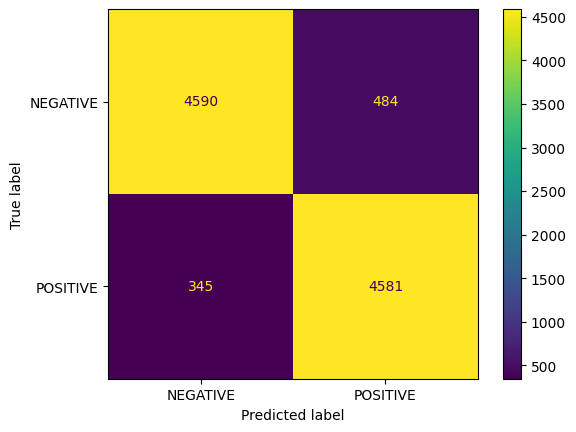

In [ ]:
matrix = confusion_matrix(df['Sentiment'] , df['cardiffnlp'])
disp = ConfusionMatrixDisplay(confusion_matrix=matrix , display_labels= ['NEGATIVE','POSITIVE'])
disp.plot()
plt.show()

In [ ]:
print(classification_report(df['Sentiment'] , df['cardiffnlp']))

              precision    recall  f1-score   support

    NEGATIVE       0.93      0.90      0.92      5074
    POSITIVE       0.90      0.93      0.92      4926

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



In [ ]:
accuracies = []
models = []
accuracies.append(accuracy_score(df['Sentiment'] , df['cardiffnlp']))
models.append("CARDIFF_NLP")


# **MODEL** - ***distilbert-base-uncased-finetuned-sst-2-english***

In [ ]:
bert = pipeline('sentiment-analysis' ,  model='distilbert-base-uncased-finetuned-sst-2-english')
bert

In [ ]:
def distill_bert_nlp(text):
  return bert(text)[0]['label']


In [ ]:
distill_bert_nlp("i love this phone")

'POSITIVE'

In [ ]:
df['Distill_BERT'] = df['review'].apply(distill_bert_nlp)

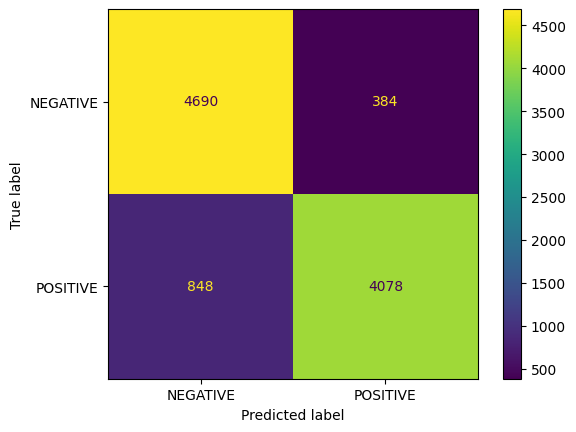

In [ ]:
matrix = confusion_matrix(df['Sentiment'] , df['Distill_BERT'])
disp = ConfusionMatrixDisplay(confusion_matrix=matrix , display_labels= ['NEGATIVE','POSITIVE'])
disp.plot()
plt.show()

In [ ]:
print(classification_report(df['Sentiment'] , df['Distill_BERT']))

              precision    recall  f1-score   support

    NEGATIVE       0.85      0.92      0.88      5074
    POSITIVE       0.91      0.83      0.87      4926

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



In [ ]:
accuracies.append(accuracy_score(df['Sentiment'] , df['Distill_BERT']))
models.append("Distill_BERT")

# **MODEL** - ***ProsusAI/finbert***

In [ ]:
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig
from scipy.special import softmax

MODEL_NAME = f"ProsusAI/finbert"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
config = AutoConfig.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME)


def finbertnlp(text) :
  encoded_input = tokenizer(text, return_tensors='pt')  # ENCODING
  output = model(**encoded_input) # PASSING TO MODEL
  scores = output[0][0].detach().numpy()  # OBTAINING SCORES
  scores = softmax(scores)  # CONVERTING THE OBTAINED SCORES TO PROBABILITIES
  ranking = np.argsort(scores) # SORTING BASED ON INDEX IN ASCENDING
  ranking = ranking[::-1] # SORTING IN DESCENDING
  d = {}  # CREATING EMPTY DICTIONARY
  for i in range(scores.shape[0]):   # ADDING LABELS IN PROBS IN DICT
    l = config.id2label[ranking[i]]
    s = scores[ranking[i]]
    # print(f"{i+1}) {l} {np.round(float(s), 4)}")
    d[l] = np.round(float(s), 4)

  del d['neutral'] # DELETING NEUTRAL CLASS
  key_with_highest_value = max(d, key=d.get) # EXTRACTING LABEL WITH HIGHEST PROB
  return key_with_highest_value.upper()



In [ ]:
# Example
finbertnlp("i love this phone")

'POSITIVE'

In [ ]:
df['FINBERT'] =  df['review'].apply(finbertnlp)

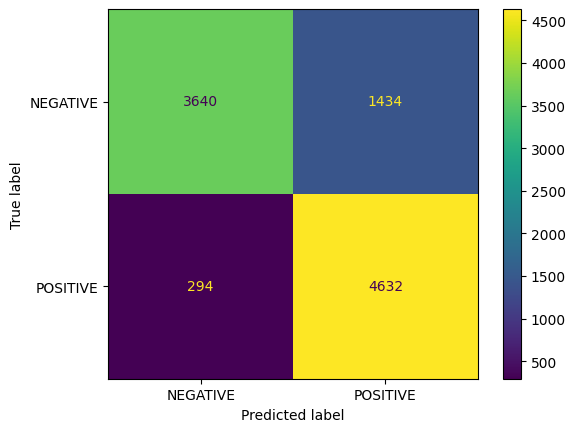

In [ ]:
matrix = confusion_matrix(df['Sentiment'] , df['FINBERT'])
disp = ConfusionMatrixDisplay(confusion_matrix=matrix , display_labels= ['NEGATIVE','POSITIVE'])
disp.plot()
plt.show()

In [ ]:
print(classification_report(df['Sentiment'] , df['FINBERT']))

              precision    recall  f1-score   support

    NEGATIVE       0.93      0.72      0.81      5074
    POSITIVE       0.76      0.94      0.84      4926

    accuracy                           0.83     10000
   macro avg       0.84      0.83      0.83     10000
weighted avg       0.85      0.83      0.83     10000



In [ ]:
accuracies.append(accuracy_score(df['Sentiment'] , df['FINBERT']))
models.append("FINBERT_NLP")

# **MODEL -** ***distilroberta-finetuned-financial-news-sentiment-analysis***

In [ ]:
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig
from scipy.special import softmax

MODEL_NAME = f"mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
config = AutoConfig.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME)


def distilroberta(text) :
  encoded_input = tokenizer(text, return_tensors='pt')  # ENCODING
  output = model(**encoded_input) # PASSING TO MODEL
  scores = output[0][0].detach().numpy()  # OBTAINING SCORES
  scores = softmax(scores)  # CONVERTING THE OBTAINED SCORES TO PROBABILITIES
  ranking = np.argsort(scores) # SORTING BASED ON INDEX IN ASCENDING
  ranking = ranking[::-1] # SORTING IN DESCENDING
  d = {}  # CREATING EMPTY DICTIONARY
  for i in range(scores.shape[0]):   # ADDING LABELS IN PROBS IN DICT
    l = config.id2label[ranking[i]]
    s = scores[ranking[i]]
    # print(f"{i+1}) {l} {np.round(float(s), 4)}")
    d[l] = np.round(float(s), 4)

  del d['neutral'] # DELETING NEUTRAL CLASS
  key_with_highest_value = max(d, key=d.get) # EXTRACTING LABEL WITH HIGHEST PROB
  return key_with_highest_value.upper()



In [ ]:
distilroberta("I did not liked this phone")

'NEGATIVE'

In [ ]:
df['DISTILL_ROBERTA'] = df['review'].apply(distilroberta)

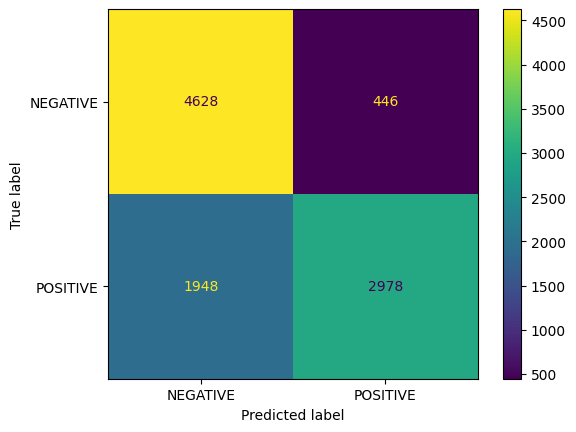

In [ ]:
matrix = confusion_matrix(df['Sentiment'] , df['DISTILL_ROBERTA'])
disp = ConfusionMatrixDisplay(confusion_matrix=matrix , display_labels= ['NEGATIVE','POSITIVE'])
disp.plot()
plt.show()

In [ ]:
print(classification_report(df['Sentiment'] , df['DISTILL_ROBERTA']))

              precision    recall  f1-score   support

    NEGATIVE       0.70      0.91      0.79      5074
    POSITIVE       0.87      0.60      0.71      4926

    accuracy                           0.76     10000
   macro avg       0.79      0.76      0.75     10000
weighted avg       0.79      0.76      0.75     10000



In [ ]:
accuracies.append(accuracy_score(df['Sentiment'] , df['DISTILL_ROBERTA']))
models.append("DISTILL_ROBERTA")

In [ ]:
STOP = time.time()
print("Time required to TEST all models : ",((STOP - START)/60) , " mins")

Time required to TEST all models :  68.25161076784134  mins


In [ ]:
visual = pd.DataFrame(index = models)
visual['Accuracy'] = accuracies

,Accuracy
CARDIFF_NLP,0.9171
Distill_BERT,0.8768
FINBERT_NLP,0.8272
DISTILL_ROBERTA,0.7606


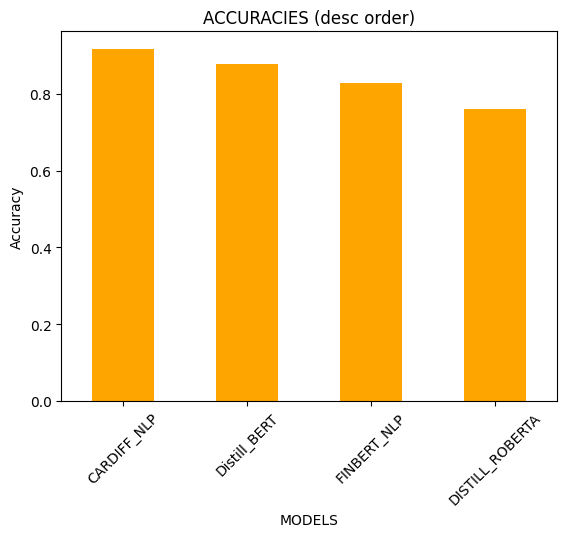

from matplotlib import pyplot as plt
_df_0['Accuracy'].plot(kind='hist', bins=20, title='Accuracy')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_1.groupby('index').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['Accuracy'].plot(kind='line', figsize=(8, 4), title='Accuracy')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_3['index'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_3, x='Accuracy', y='index', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [ ]:
display(visual.sort_values(ascending = False , by ='Accuracy'))
visual['Accuracy'].sort_values(ascending = False).plot(kind='bar',color='orange')
plt.xlabel("MODELS")
plt.ylabel("Accuracy")
plt.title("ACCURACIES (desc order)")
plt.xticks(rotation=45)
plt.show()

***As we see , the RoBERTa based model (trained on 124M tweets from January 2018 to December 2021, and finetuned for sentiment analysis with the TweetEval benchmark) gives the highest accuracy of 91 % , so we will use it for our further predictions.***